# makemore_MLP

----
* Inspired by Andrej Karpathy's ["Building makemore Part 2: MLP"](https://www.youtube.com/watch?v=TCH_1BHY58I)

* Useful links 
    - [PyTorch internals reference](http://blog.ezyang.com/2019/05/pytorch-internals/)
    ```
    "...The talk is in two parts: in the first part, I'm going to first introduce you to the conceptual universe of a tensor library ... The second part grapples with the actual nitty gritty details involved with actually coding in PyTorch..." - Edward Z. Yang
    ```


# Table of Contents
------------------
- [0. Makemore: Introduction](#0)
    - [0.1. "A Neural Probabilistic Language Model" - Bengio et al. 2003, Paper Walkthrough](#001)
- [1. Re-building our Training Dataset](#1)
- [2. Multilayer Perceptron (MLP)](#2)
    - [2.1. Embedding Lookup Table](#201)
    - [2.2. Hidden Layer + `torch.Tensor` Internals (storage, views)](#202)
    - [2.3. Output Layer](#203)
    - [2.4. Negative Log Likelihood Loss](#204)
    - [2.5. Summary of the Full Network](#205)
    - [2.6. `F.cross_entropy` & Why?](#206)
    - [2.7. Training Loop + Overfitting One Batch](#207)
    - [2.8. Training on the Full Dataset + Minibatches](#208)
    - [2.9. Learning Rate](#209)
    - [2.10. Train-Val-Test Splits & Why?](#210)
    - [2.11. Experiment: Larger Hidden Layer](#211)
    - [2.12. Visualize Character Embeddings](#212)
    - [2.13. Experiment: Larger Embedding Size](#213)
    - [2.14. Summary of Final Code](#214)
    - [2.15. Sampling from the Model](#215)
- [3. Conclusion](#3)
------



# Appendix
---------------
## Figures
- [A1: Neural Architecture.](#a1)

## Definitions/Explanations
- [D0. The Neural Model: Bengio et. al. 2003 paper (Section 2)](#d0)
- [D1. Curse of Dimensionality](#d1)
- [D2. Model Parameters](#d2)
- [D3. Hyperparameters to Optimize](#d3)
- [D4. Tensor Manipulations](#d4)
- [D5. Embeddings](#d5)


## [Exercises](#e1)

## [References](#r1)

-----------
<br><br>
# 0. Makemore: Introduction<a id="0"></a>
---------------------------------
<u>**Makemore**</u> takes one text file as input, where each line is assumed to be one training thing, and generates more things like it. Under the hood, it is an **autoregressive character-level language model**, with a <u>wide choice of models from bigrams all the way to a Transformer (exactly as seen in GPT)</u>. An [autoregressive model](https://en.wikipedia.org/wiki/Autoregressive_model) specifies that the output variable depends linearly on its own previous values and on a stochastic term (an imperfectly predictable term). For example, we can feed it a database of names, and makemore will generate cool baby name ideas that all sound name-like, but are not already existing names. Or if we feed it a database of company names then we can generate new ideas for a name of a company. Or we can just feed it valid scrabble words and generate english-like babble. 
```
"As the name suggests, makemore makes more."
```
This is not meant to be too heavyweight of a library with a billion switches and knobs. It is one hackable file, and is mostly intended for educational purposes. [PyTorch](https://pytorch.org) is the only requirement.

Current implementation follows a few key papers:

- Bigram (one character predicts the next one with a lookup table of counts)
- MLP, following [Bengio et al. 2003](https://www.jmlr.org/papers/volume3/bengio03a/bengio03a.pdf)
- CNN, following [DeepMind WaveNet 2016](https://arxiv.org/abs/1609.03499) (in progress...)
- RNN, following [Mikolov et al. 2010](https://www.fit.vutbr.cz/research/groups/speech/publi/2010/mikolov_interspeech2010_IS100722.pdf)
- LSTM, following [Graves et al. 2014](https://arxiv.org/abs/1308.0850)
- GRU, following [Kyunghyun Cho et al. 2014](https://arxiv.org/abs/1409.1259)
- Transformer, following [Vaswani et al. 2017](https://arxiv.org/abs/1706.03762)

In the 1st makemore tutorial notebook, we worked on a bigram model that takes into account only the local context of a word. This approach is impractical as the size of the counting matrix (also represent model’s weights) grows rapidly when we increase the context, i.e. takes more characters. For example, the first dimension of the counting matrix increases from 27 to 27x27 = 729 when we switch from bigram to trigram model.

As seen above expanding the context requires a larger lookup table, but with a vast vocabulary, this approach becomes impractical. This explosion in possible combinations means the model needs a huge amount of data to learn effectively from all these combinations. Yet, in reality, encountering all these combinations in training is unlikely, making accurate predictions on unseen sequences difficult. This challenge is known as the <a id='d1'></a>**curse of dimensionality**: 
```
as the vocabulary increases, the number of possible combinations to learn increase exponentially, hindering the model’s learning and generalization capabilities.
```

In summary essentially, <u>curse of dimensionality</u> refers to the exponential growth in complexity and data requirements as the number of features (words or characters) increases, hindering the model’s ability to generalize effectively. Therefore, we want to have a model that is easy to generalize.

In this notebook, we want to implement a multilayer perceptron (MLP) character-level language model. We will also introduce many basics of machine learning (e.g. model training, learning rate tuning, hyperparameters, evaluation, train/dev/test splits, under/overfitting, etc.). We will go through the **Bengio et al. 2003 paper** which offers a solution with dealing with the curse of dimensionality.

---
<a id="001"></a>
## 0.1.  "A Neural Probabilistic Language Model" - Bengio et al. 2003, Paper Walkthrough
-----

<u>Abstract:</u>
A goal of statistical language modeling is to learn the joint probability function of sequences of words in a language. This is intrinsically difficult because of the **curse of dimensionality**: a word sequence on which the model will be tested is likely to be different from all the word sequences seen during training. Traditional but very successful approaches based on n-grams obtain generalization by concatenating very short overlapping sequences seen in the training set. We propose to fight the curse of dimensionality by **learning a distributed representation for words** which allows each training sentence to inform the model about an exponential number of semantically neighboring sentences. The model learns simultaneously 
1. a distributed representation for each word along with 
2. the probability function for word sequences, expressed in terms of these representations. 

Generalization is obtained because a sequence of words that has never been seen before gets high probability if it is made of words that are similar (in the sense of having a nearby representation) to words forming an already seen sentence. Training such large models (with millions of parameters) within a reasonable time is itself a significant challenge. We report on experiments using neural networks for the probability function, showing on two text corpora that the proposed approach significantly improves on state-of-the-art n-gram models, and that the proposed approach allows to take advantage of longer contexts. 

**Keywords**: Statistical language modeling, artificial neural networks, distributed representation, curse of dimensionality

---

In the model proposed here, instead of characterizing the similarity with a discrete random or deterministic variable (which corresponds to a soft or hard partition of the set of words), we use a continuous real-vector for each word, i.e. **a learned distributed feature vector**, to represent similarity between words.

In this paper, they used a vocabulary of 17000 words with each word mapped to a 30-dimensional embedding via a lookup table/embedding matrix. The number of neurons in the hidden layer is a hyper-parameter. All of them are fully connected to the input layer. The output layer has 17000 neurons, one for each word. On top of the 17000 logits, we have a softmax layer. Weights and biases of the output layer, weights and biases of the hidden layer, and the embedding lookup table are the parameters we can adjust.The architecture of their neural network is shown in the figure below.


The model takes several previous characters (*context*) and tries to predict the next one. In the figure above, the context consists of three characters, but the number can be more. Since our model cannot work directly with characters, we convert characters to integers (indexes). The input layer takes the indexes of all context characters and converts them into embedding vectors using a lookup table C. The size of the embedding vector is a network parameter. The lookup table is shared across characters and has a size of *number of unique characters X embedding vector size.*

The hidden layer is fully connected to the previous layer and receives one concatenated output from it. The `tanh` function is used as a non-linearity function. The output layer is also fully connected and consists of the number of neurons equal to the total number of unique characters in the dataset. It produces **logits** which are then converted to **probabilities** using the **softmax** function. The character with the <u>highest probability</u> is our prediction. The <u>network parameters are optimized using back-propagation.</u>



In the model proposed here, instead of characterizing the similarity with a discrete random or deterministic variable (which corresponds to a soft or hard partition of the set of words), we use a continuous real-vector for each word, i.e. **a learned distributed feature vector**, to represent similarity between words.




<a id="a1"></a>
![NN architecture](_imgs/bengio_et_al_2003_NN_MLP_architecture_.png)

**Figure 1: Neural architecture: $f\left(i, w_{t-1}, \cdots, w_{t-n+1}\right)=g\left(i, C\left(w_{t-1}\right), \cdots, C\left(w_{t-n+1}\right)\right)$ where $g$ is the neural network and $C(i)$ is the $i$-th word feature vector.** ([Source](https://www.jmlr.org/papers/volume3/bengio03a/bengio03a.pdf))

---------
<br><br>
# 1. Re-building our Training Dataset<a id="1"></a>
-------------------------------------------------------

In [1]:
import torch
import torch.nn.functional as F
import random

import matplotlib.pyplot as plt
%matplotlib inline

In [2]:
# read all the names into a list of words
words = open('../data/names.txt', 'r').read().splitlines()
words[:8]

['emma', 'olivia', 'ava', 'isabella', 'sophia', 'charlotte', 'mia', 'amelia']

In [3]:
len(words)

32033

In [4]:
# build the vocabulary of characters and mappings to/from integers
chars = sorted(list(set(''.join(words))))
stoi = {s:i+1 for i,s in enumerate(chars)}
stoi['.'] = 0
itos = {i:s for s,i in stoi.items()}
print(itos)

{1: 'a', 2: 'b', 3: 'c', 4: 'd', 5: 'e', 6: 'f', 7: 'g', 8: 'h', 9: 'i', 10: 'j', 11: 'k', 12: 'l', 13: 'm', 14: 'n', 15: 'o', 16: 'p', 17: 'q', 18: 'r', 19: 's', 20: 't', 21: 'u', 22: 'v', 23: 'w', 24: 'x', 25: 'y', 26: 'z', 0: '.'}


In [5]:
# build the dataset

block_size = 3 # context length: how many characters do we take to predict the next one?
X, Y = [], []
for w in words[:5]:
    
    print(w)
    context = [0] * block_size # start with padded context of just zero tokens
    #print(context)
    for char in w + '.':
        ix = stoi[char]
        X.append(context)
        Y.append(ix)
        #print(ix)
        print(''.join(itos[i] for i in context), '--->', itos[ix])
        context = context[1:] + [ix] # crop context and append
        #print(context)
        
X = torch.tensor(X)
Y = torch.tensor(Y)
        

emma
... ---> e
..e ---> m
.em ---> m
emm ---> a
mma ---> .
olivia
... ---> o
..o ---> l
.ol ---> i
oli ---> v
liv ---> i
ivi ---> a
via ---> .
ava
... ---> a
..a ---> v
.av ---> a
ava ---> .
isabella
... ---> i
..i ---> s
.is ---> a
isa ---> b
sab ---> e
abe ---> l
bel ---> l
ell ---> a
lla ---> .
sophia
... ---> s
..s ---> o
.so ---> p
sop ---> h
oph ---> i
phi ---> a
hia ---> .


In [6]:
X.shape, X.dtype, Y.shape, Y.dtype

(torch.Size([32, 3]), torch.int64, torch.Size([32]), torch.int64)

In [7]:
Y

tensor([ 5, 13, 13,  1,  0, 15, 12,  9, 22,  9,  1,  0,  1, 22,  1,  0,  9, 19,
         1,  2,  5, 12, 12,  1,  0, 19, 15, 16,  8,  9,  1,  0])

---------
<br><br>
# 2. Multilayer Perceptron (MLP)<a id="2"></a>
-------------------------------------------------------

Let's implement a neural probabilistic language model that handles some of the limitations (poor generalization, exponential growth in complexity) of the n-gram character-level language models we've implemented in previous tutorials so far. We will build a <u>multilayer perceptron (MLP)</u> model. An MLP model doesn't rely on exact sequence matches, and learns syntatic & semantic similarities between different words. This enables better model generalization to unseen data.

------
## 2.1. Embedding Lookup Table<a id="201"></a>
-----

We need to build the neural network that takes `X` and predicts `Y`. However, first we need to build the embedding lookup table `C` which we initialize randomly in the beginning. We have **27 possible characters** which we are going to embed in a lower-dimensional space (**2-D**). In the paper, they embed **17000 words into a 30-dimensional space**.

We can use one-hot vectors to extract embeddings. Therefore, we can assume that the lookup table itself is a layer of the neural network without a non-linearity. However, we will be using indexing due to its efficiency. Indexing can be done for 1-D, and multi-dimensional tensors of integers.

In [8]:
C = torch.randn((27, 2))

In [9]:
C[5]

tensor([ 0.0795, -1.1500])

In [10]:
F.one_hot(torch.tensor(5), num_classes=27).float() @ C

tensor([ 0.0795, -1.1500])

In [11]:
C[X].shape

torch.Size([32, 3, 2])

In [12]:
X[13, 2]

tensor(1)

In [13]:
C[1]

tensor([ 0.1649, -0.0402])

In [14]:
C[X][13, 2]

tensor([ 0.1649, -0.0402])

In [15]:
emb = C[X]
emb.shape

torch.Size([32, 3, 2])

------
## 2.2.  Hidden Layer + `torch.Tensor` Internals (storage, views)<a id="202"></a>
-----
Let's construct the hidden layer shown in Figure 1 previously. For the 1st hidden layer, the **inputs would be 6** because there would be two values in the embedding table for each of the three characters (**2 X 3**). The hidden layer, with 100 neurons, processes the embedded vectors. We use a `tanh` activation function here to introduce non-linearity and the outputs lie in this range `[-1, 1]`.


In [16]:
W1 = torch.randn((6, 100))
b1 = torch.randn(100)

In [17]:
#emb @ W1 + b1 #RuntimeError: mat1 and mat2 shapes cannot be multiplied (96x2 and 6x100)

We need to ensure that `emb` can be matrix multiplied by `W1`. So we need to transform the shape of the embeddings `emb` to ensure matrix multiplication is possible. We need to concatenate `emb` to make this possible. Torch has many ways of implementing matrix transformations due to it being a very large library.

In [18]:
torch.cat([emb[:, 0, :], emb[:, 1, :], emb[:, 2, :]], 1).shape # dependent on block size

torch.Size([32, 6])

In [19]:
torch.cat(torch.unbind(emb, 1), 1).shape # independent of block size

torch.Size([32, 6])

In [20]:
emb.view(emb.shape[0], 6) == torch.cat(torch.unbind(emb, 1), 1)

tensor([[True, True, True, True, True, True],
        [True, True, True, True, True, True],
        [True, True, True, True, True, True],
        [True, True, True, True, True, True],
        [True, True, True, True, True, True],
        [True, True, True, True, True, True],
        [True, True, True, True, True, True],
        [True, True, True, True, True, True],
        [True, True, True, True, True, True],
        [True, True, True, True, True, True],
        [True, True, True, True, True, True],
        [True, True, True, True, True, True],
        [True, True, True, True, True, True],
        [True, True, True, True, True, True],
        [True, True, True, True, True, True],
        [True, True, True, True, True, True],
        [True, True, True, True, True, True],
        [True, True, True, True, True, True],
        [True, True, True, True, True, True],
        [True, True, True, True, True, True],
        [True, True, True, True, True, True],
        [True, True, True, True, T

In [21]:
# making sure broadcasting works as expected: element-wise addition
# 32, 100    ---> 32, 100
#     100    --->  1, 100
(emb.view(-1, 6) @ W1).shape, b1.shape

(torch.Size([32, 100]), torch.Size([100]))

In [22]:
h = torch.tanh(emb.view(-1, 6) @ W1 + b1)
h

tensor([[ 0.9989, -0.5693,  0.8112,  ..., -0.7093, -0.9864,  0.6689],
        [ 0.1384, -0.0799, -0.9994,  ...,  0.9321,  0.9163, -0.1549],
        [ 0.6756,  0.8763,  0.0039,  ...,  0.5831,  0.9628,  0.7309],
        ...,
        [-0.4285,  0.9701, -0.9946,  ...,  0.9994,  1.0000,  0.2847],
        [-0.8484, -0.4393,  0.9855,  ..., -0.9131, -0.9705,  0.9912],
        [ 0.7571, -0.9000,  0.6245,  ..., -0.4636, -0.9902,  0.7642]])

In [23]:
(emb.view(-1, 6) @ W1).shape

torch.Size([32, 100])

In [24]:
h.shape

torch.Size([32, 100])

In [25]:
b1.shape

torch.Size([100])

------
## 2.3. Output Layer<a id="203"></a>
-----
Let’s create the output layer. The output layer computes logits which are then converted to a probability distribution. This layer is crucial for generating the final character predictions.


In [26]:
W2 = torch.randn((100, 27))
b2 = torch.randn(27)

In [27]:
logits = h @ W2 + b2

------
## 2.4.  Negative Log Likelihood Loss<a id="204"></a>
-----

Next, using the logits, we must calculate the probabilities and the average negative log-likelihood loss. The loss is calculated using the probability distribution, which helps in updating the network’s parameters through backpropagation


In [28]:
counts = logits.exp()

In [29]:
prob = counts / counts.sum(1, keepdim=True)

In [30]:
prob[0].sum()

tensor(1.)

In [31]:
Y

tensor([ 5, 13, 13,  1,  0, 15, 12,  9, 22,  9,  1,  0,  1, 22,  1,  0,  9, 19,
         1,  2,  5, 12, 12,  1,  0, 19, 15, 16,  8,  9,  1,  0])

In [32]:
torch.arange(32)  

tensor([ 0,  1,  2,  3,  4,  5,  6,  7,  8,  9, 10, 11, 12, 13, 14, 15, 16, 17,
        18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31])

In [33]:
prob[torch.arange(32), Y]   # 32 = shape of input X

tensor([2.0816e-03, 9.8024e-05, 8.0746e-09, 3.6231e-06, 3.7387e-05, 7.2478e-09,
        3.4388e-11, 1.2536e-08, 3.7001e-12, 5.4971e-07, 8.6313e-13, 1.9187e-05,
        1.6919e-11, 1.5080e-05, 8.3559e-19, 7.8019e-04, 1.1049e-06, 5.4742e-03,
        6.0078e-17, 3.2374e-04, 8.4933e-09, 3.1721e-11, 4.0807e-12, 3.5842e-07,
        8.3485e-07, 3.9156e-01, 1.3974e-06, 3.8203e-11, 1.4490e-02, 3.9155e-07,
        8.9099e-09, 1.6840e-04])

In [34]:
prob[torch.arange(32), Y].log().mean()

tensor(-16.5189)

------
## 2.5.  Summary of the Full Network<a id="205"></a>
-----
Let's take a look at an excerpt of the neural model in the paper before we put it all together in the model.

----
<a id="d0"></a>
### Relevant Excerpt from the Bengio et. al. 2003 paper (Section 2)
----
**Section 2: A Neural Model**

The training set is a sequence $w_{1} \cdots w_{T}$ of words $w_{t} \in V$, where the vocabulary $V$ is a large but finite set. The objective is to learn a good model $f\left(w_{t}, \cdots, w_{t-n+1}\right)=\hat{P}\left(w_{t} \mid w_{1}^{t-1}\right)$, in the sense that it gives high out-of-sample likelihood. Below, we report the geometric average of $1 / \hat{P}\left(w_{t} \mid w_{1}^{t-1}\right)$, also known as perplexity, which is also the exponential of the average negative log-likelihood. The only constraint on the model is that for any choice of $w_{1}^{t-1}, \sum_{i=1}^{|V|} f\left(i, w_{t-1}, \cdots, w_{t-n+1}\right)=1$, with $f>0$. By the product of these conditional probabilities, one obtains a model of the joint probability of sequences of words.

We decompose the function $f\left(w_{t}, \cdots, w_{t-n+1}\right)=\hat{P}\left(w_{t} \mid w_{1}^{t-1}\right)$ in two parts:

1. A mapping $C$ from any element $i$ of $V$ to a real vector $C(i) \in \mathbb{R}^{m}$. It represents the distributed feature vectors associated with each word in the vocabulary. In practice, $C$ is represented by a $|V| \times m$ matrix of free parameters.

2. The probability function over words, expressed with $C$ : a function $g$ maps an input sequence of feature vectors for words in context, $\left(C\left(w_{t-n+1}\right), \cdots, C\left(w_{t-1}\right)\right)$, to a conditional probability distribution over words in $V$ for the next word $w_{t}$. The output of $g$ is a vector whose $i$-th element estimates the probability $\hat{P}\left(w_{t}=i \mid w_{1}^{t-1}\right)$ as in Figure 1.

$$
f\left(i, w_{t-1}, \cdots, w_{t-n+1}\right)=g\left(i, C\left(w_{t-1}\right), \cdots, C\left(w_{t-n+1}\right)\right)
$$

The function $f$ is a composition of these two mappings ( $C$ and $g$ ), with $C$ being shared across all the words in the context. With each of these two parts are associated some parameters. The parameters of the mapping $C$ are simply the feature vectors themselves, represented by a $|V| \times m$ matrix $C$ whose row $i$ is the feature vector $C(i)$ for word $i$. The function $g$ may be implemented by a feed-forward or recurrent neural network or another parametrized function, with parameters $\omega$. The overall parameter set is $\theta=(C, \omega)$.

Training is achieved by looking for $\theta$ that maximizes the training corpus penalized log-likelihood:

$$
L=\frac{1}{T} \sum_{t} \log f\left(w_{t}, w_{t-1}, \cdots, w_{t-n+1} ; \theta\right)+R(\theta)
$$

where $R(\theta)$ is a regularization term. For example, in our experiments, **$R$ is a weight decay penalty applied only to the weights of the neural network and to the $C$ matrix, not to the biases**. ${ }^{3}$

In the above model, the number of free parameters **only scales linearly** with $V$, the number of words in the vocabulary. It also **only scales linearly** with the order $n$ : the scaling factor could be reduced to sub-linear if more sharing structure were introduced, e.g. using a time-delay neural network or a recurrent neural network (or a combination of both).

In most experiments below, the neural network has one hidden layer beyond the word features mapping, and optionally, direct connections from the word features to the output. Therefore there are really two hidden layers: the shared word features layer $C$, which has no non-linearity (it would not add anything useful), and the ordinary hyperbolic tangent hidden layer. More precisely, the neural network computes the following function, with a softmax output layer, which guarantees positive probabilities summing to 1 :

$$
\hat{P}\left(w_{t} \mid w_{t-1}, \cdots w_{t-n+1}\right)=\frac{e^{y_{w_{t}}}}{\sum_{i} e^{y_{i}}}
$$


The $y_{i}$ are the unnormalized log-probabilities for each output word $i$, computed as follows, with parameters $b, W, U, d$ and $H$ :

$$
\begin{equation*}
y=b+W x+U \tanh (d+H x) \tag{1}
\end{equation*}
$$

where the hyperbolic tangent tanh is applied element by element, $W$ is optionally zero (no direct connections), and $x$ is the word features layer activation vector, which is the concatenation of the input word features from the matrix $\mathrm{C}$ :

$$
x=\left(C\left(w_{t-1}\right), C\left(w_{t-2}\right), \cdots, C\left(w_{t-n+1}\right)\right)
$$

Let 
* $h$ be the number of hidden units, and 
* $m$ the number of features associated with each word. 

When no direct connections from word features to outputs are desired, the matrix $W$ is set to 0 . The free parameters of the model are 
* the output biases $b$ (with $|V|$ elements), 
* the hidden layer biases $d$ (with $h$ elements), 
* the hidden-to-output weights $U$ (a $|V| \times h$ matrix), 
* the word features to output weights $W$ (a $|V| \times(n-1) m$ matrix), 
* the hidden layer weights $H$ (a $h \times(n-1) m$ matrix), and 
* the word features $C$ (a $|V| \times m$ matrix)

$$
\theta=(b, d, W, U, H, C)
$$

The number of free parameters is $|V|(1+n m+h)+h(1+(n-1) m)$. The dominating factor is $|V|(n m+h)$. Note that in theory, if there is a weight decay on the weights $W$ and $H$ but not on $C$, then $W$ and $H$ could converge towards zero while $C$ would blow up. In practice we did not observe such behavior when training with stochastic gradient ascent.

Stochastic gradient ascent on the neural network consists in performing the following iterative update after presenting the $t$-th word of the training corpus:

$$
\theta \leftarrow \theta+\varepsilon \frac{\partial \log \hat{P}\left(w_{t} \mid w_{t-1}, \cdots w_{t-n+1}\right)}{\partial \theta}
$$

where $\varepsilon$ is the "learning rate". Note that a large fraction of the parameters needs not be updated or visited after each example: the word features $C(j)$ of all words $j$ that do not occur in the input window.

---
**${ }^{3}$ The $biases$ are the additive parameters of the neural network, such as $b$ and $d$ in equation 1 below.**

----
<a id="d2"></a>
Now, with knowledge from the excerpt above of the model parameters, their meanings and shapes; let's combine the previous steps to get a picture of the whole MLP neural network. The general parameters from the paper are:
* `V` = vocabulary size (total number of characters)
* `n` = the number of characters fed in as input as **context** into the model: block_size
* `m` = number of features associated with each character/ lower-dimensional space
* `C` = embedding lookup table matrix 
    - `|V| * m` = size of `C`
    - `C[i]` = feature vector for **word i**
* Weights
    - <u>`H`, hidden layer weight matrix,</u> (size: `h * (nm)`) --> `W1` 
    - <u>`U`, hidden-to-output weight matrix,</u> (size: `|V| * h`) --> `W2`
    - <u>`W`, word features to output weight matrix,</u> (size: `|V| * (nm)`) --> `W3`
* `b` = output bias matrix -->  (size: `|V|`) --> `b2`
* `d` = hidden layer bias matrix -->  (size: `h`) --> `b1`
* The number of free parameters: `|V|(1+(n+1)m+h) + h(1+nm)`
* The number of free parameters excluding the use of `W3`: `|V|(1+m+h) + h(1+nm)`


$$
\begin{equation*}
y=b+W x+U \tanh (d+H x) \tag{1}
\end{equation*}
$$
<br>
$$
parameters: \theta=(b, d, W, U, H, C)
$$

In our case, these are our parameters sizes:
* `n`: 3 (block_size)
* `m`: 2 lower-dimensional space (arbitrary choice)
* `V`: 27 characters (26 alphabets + `.` character)
* `C`: 27 $\times$ 2 (vocabulary size $\times$ m)
* <u>input layer</u>: 6 nodes - 3 $\times$ 2 (number of input characters $\times$ m)
* `W1`: 6 $\times$ 100 (input features $\times$ number of neurons in next (hidden) layer) 
* `b1`: 100 hidden layer elements
* <u>hidden layer</u>: 100 (100 neurons is a hyperparameter we chose to start with)
* `W2`: 100 $\times$ 27 (number of neurons in previous (hidden) layer $\times$ number of neurons in next (output) layer) 
* `b2`: 27 output layer elements
* <u>output layer</u>: 27 neurons
* <u>The number of free parameters (excluding 
    `W3`)</u>: `(27 * 2) + (6 * 100) + (100 * 27) + 100 + 27`
    - Using the general parameters' equation above (excluding the use of `W3`): `27*(1 + (1)*2 + 100) + 100*(1 + 3*2)`
    - Both ways should give the same answer of `3481`
    
$$
\begin{equation*}
y=b_{2}+W_{2} \tanh (b_{1}+W_{1} x) \tag{2}
\end{equation*}
$$
<br>
$$
parameters: \theta=(b_{1}, b_{2}, W_{1}, W_{2}, C)
$$

---

In [35]:
27*(1 + (1)*2 + 100) + 100*(1 + 3*2), (27 * 2) + (6 * 100) + (100 * 27) + 100 + 27

(3481, 3481)

In [36]:
X.shape, Y.shape                                  # dataset

(torch.Size([32, 3]), torch.Size([32]))

In [37]:
# ------------------- MLP Implementation ---------------------------------
g = torch.Generator().manual_seed(2147483647)     # for reproducibility
C = torch.randn((27, 2), generator=g)
W1 = torch.randn((6, 100), generator=g)
b1 = torch.randn(100, generator=g)
W2 = torch.randn((100, 27), generator=g)
b2 = torch.randn(27, generator=g)
parameters = [C, W1, b1, W2, b2]

In [38]:
par_count = 0
for par in parameters:
    if len(par.shape) == 2:                        # [C, W1, W2]
        par_count += par.shape[0]*par.shape[1]
    else:                                          # [b1, b2]
        par_count += par.shape[0]
print(par_count)

3481


In [39]:
27*2 + 6*100 + 100 + 100*27 + 27

3481

In [40]:
sum(p.nelement() for p in parameters)             # number of parameters in total

3481

In [41]:
emb = C[X] # (32, 3, 2)
h = torch.tanh(emb.view(-1,6) @ W1 + b1) # (32,100)
logits = h @ W2 + b2 # (32, 27)
counts = logits.exp()
probs = counts/counts.sum(1, keepdim=True) # (32, 27)
loss = -probs[torch.arange(32), Y].log().mean()
loss

tensor(17.7697)

------
## 2.6.  `F.cross_entropy` & Why?<a id="206"></a>
-----
<a id="d1"></a>


We can calculate the classification error efficiently using the `F.cross_entropy()` function. In real-world applications, we prefer this approach. In our approach to calculating the loss, we made a few intermediate tensors which is fairly inefficient. However, `F.cross_entropy()` uses in-built fused kernels to calculate the loss directly. Moreover, backpropagation is also efficient (simpler backward pass to implement) since we use clustered mathematical operations.

`F.cross_entropy()` is significantly more numerically stable compared to the approach in the previous section. It does not produce errors when extremely positive inputs are given unlike `exp()`. In general, **cross-entropy loss** is a metric used in machine learning to measure the performance of a classification model.

In [42]:
F.cross_entropy(logits, Y)

tensor(17.7697)

------
## 2.7.  Training Loop + Overfitting One Batch<a id="207"></a>
-----

Now let's implement the training loop of forward pass, backward pass and parameter updates


In [43]:
# ------------------- MLP Implementation ---------------------------------
g = torch.Generator().manual_seed(2147483647)     # for reproducibility
C = torch.randn((27, 2), generator=g)
W1 = torch.randn((6, 100), generator=g)
b1 = torch.randn(100, generator=g)
W2 = torch.randn((100, 27), generator=g)
b2 = torch.randn(27, generator=g)
parameters = [C, W1, b1, W2, b2]

In [44]:
for p in parameters:
    p.requires_grad = True

for _ in range(1000):
    # forward pass
    emb = C[X]                               # (32, 3, 2)
    h = torch.tanh(emb.view(-1,6) @ W1 + b1) # (32,100)
    logits = h @ W2 + b2                     # (32, 27)
    loss = F.cross_entropy(logits, Y)
    
    # backward pass
    for p in parameters:
        p.grad = None
    loss.backward()

    # update parameters
    for p in parameters:
        p.data += -0.1 * p.grad

print(loss.item())

0.2561391294002533


In [45]:
logits.max(1)

torch.return_types.max(
values=tensor([13.3348, 17.7904, 20.6014, 20.6121, 16.7355, 13.3348, 15.9983, 14.1722,
        15.9145, 18.3614, 15.9395, 20.9265, 13.3348, 17.1090, 17.1319, 20.0602,
        13.3348, 16.5893, 15.1017, 17.0581, 18.5860, 15.9670, 10.8740, 10.6871,
        15.5056, 13.3348, 16.1795, 16.9743, 12.7426, 16.2009, 19.0845, 16.0196],
       grad_fn=<MaxBackward0>),
indices=tensor([19, 13, 13,  1,  0, 19, 12,  9, 22,  9,  1,  0, 19, 22,  1,  0, 19, 19,
         1,  2,  5, 12, 12,  1,  0, 19, 15, 16,  8,  9,  1,  0]))

In [46]:
Y

tensor([ 5, 13, 13,  1,  0, 15, 12,  9, 22,  9,  1,  0,  1, 22,  1,  0,  9, 19,
         1,  2,  5, 12, 12,  1,  0, 19, 15, 16,  8,  9,  1,  0])

---
Right now, we're only **overfitting** $32$ examples of the $1$st $5$ words. Therefore, it's very easy to make this neural network fit only these $32$ examples because we have over $3400$ parameters. So we're overfitting a single batch of the data and getting a very small loss and subsequently good predictions. Basically, we have so many parameters for very few examples, which makes it very easy to train and fit the model.

---

------
## 2.8.  Training on the Full Dataset + Minibatches<a id="208"></a>
-----
We have a large number of examples (over $220,000$), and we need to calculate parameter gradients for all of them. Each iteration takes more time compared to working with a smaller dataset. Processing over $220,000$ examples through forward and backward passes is excessively laborious.

Hence, we will execute forward and backward passes and perform updates on <u>many smaller batches of data.</u> We will randomly select a portion of the dataset (our **mini-batch**), and perform forward pass, backward pass and parameter updates exclusively on that batch, and then iterate over the many batches in the dataset.

In [47]:
# build the dataset

block_size = 3 # context length: how many characters do we take to predict the next one?
X, Y = [], []
for w in words:
    context = [0] * block_size # start with padded context of just zero tokens
    for char in w + '.':
        ix = stoi[char]
        X.append(context)
        Y.append(ix)
        context = context[1:] + [ix] # crop context and append
        
X = torch.tensor(X)
Y = torch.tensor(Y)

In [48]:
X.shape, Y.shape                                  # dataset

(torch.Size([228146, 3]), torch.Size([228146]))

In [49]:
torch.randint(0, X.shape[0], (32, ))

tensor([167880,  65556, 167199, 114265,  44013, 109392,  87178,  19177,  51653,
         70472, 214704,  13043,  98079, 137395, 176582, 224226, 168103,  10475,
         23089,  36106,  18860,  97111,  84437,  92120, 159954, 190704, 139401,
        156509,  20076, 226111,   1477, 211735])

In [50]:
g = torch.Generator().manual_seed(2147483647)     # for reproducibility
C = torch.randn((27, 2), generator=g)
W1 = torch.randn((6, 100), generator=g)
b1 = torch.randn(100, generator=g)
W2 = torch.randn((100, 27), generator=g)
b2 = torch.randn(27, generator=g)
parameters = [C, W1, b1, W2, b2]

In [51]:
sum(p.nelement() for p in parameters)             # number of parameters in total

3481

In [52]:
for p in parameters:
    p.requires_grad = True

In [53]:
for _ in range(10000):
    
    # minibatch construct
    ix = torch.randint(0, X.shape[0], (32, ))
    
    # forward pass
    emb = C[X[ix]]                               # (32, 3, 2)
    h = torch.tanh(emb.view(-1,6) @ W1 + b1)     # (32,100)
    logits = h @ W2 + b2                         # (32, 27)
    loss = F.cross_entropy(logits, Y[ix])
    
    # backward pass
    for p in parameters:
        p.grad = None
    loss.backward()

    # update parameters
    lr = 0.01
    for p in parameters:
        p.data += -lr * p.grad

print(loss.item())

2.552823066711426


In [54]:
emb = C[X]                                   # (32, 3, 2)
h = torch.tanh(emb.view(-1,6) @ W1 + b1)     # (32,100)
logits = h @ W2 + b2                         # (32, 27)
loss = F.cross_entropy(logits, Y)
loss

tensor(2.5695, grad_fn=<NllLossBackward0>)

---
Since we're only dealing with mini-batches, the quality of our gradient is lower so the direction is not as reliable because it's not the actual gradient direction. However, the mini-batch gradient direction is good enough even when it's estimating on only a subset of the dataset (i.e. in our case, $32$ examples). In fact, <u>approximating the gradient and taking more steps is often better than calculating the exact gradient and taking fewer steps</u>. This is why in practice, minibatches work quite well.

---

------
## 2.9.  Learning Rate<a id="209"></a>
-----
How do we determine the learning rate? How do we gain confidence that we're stepping with the right speed? Are we stepping too slow or too fast during gradient descent?

A very low learning rate will impede the pace of learning for the model (the loss barely decreases) and a very high learning rate will make the model unstable (the loss explodes).

In [55]:
g = torch.Generator().manual_seed(2147483647)     # for reproducibility
C = torch.randn((27, 2), generator=g)
W1 = torch.randn((6, 100), generator=g)
b1 = torch.randn(100, generator=g)
W2 = torch.randn((100, 27), generator=g)
b2 = torch.randn(27, generator=g)
parameters = [C, W1, b1, W2, b2]

In [56]:
sum(p.nelement() for p in parameters)             # number of parameters in total

3481

In [57]:
for p in parameters:
    p.requires_grad = True

In [58]:
lre = torch.linspace(-3, 0, 1000)
lrs = 10**lre

In [59]:
lri = []
lrei = []
lossi = []
for i in range(1000):
    
    # minibatch construct
    ix = torch.randint(0, X.shape[0], (32, ))
    
    # forward pass
    emb = C[X[ix]]                               # (32, 3, 2)
    h = torch.tanh(emb.view(-1,6) @ W1 + b1)     # (32,100)
    logits = h @ W2 + b2                         # (32, 27)
    loss = F.cross_entropy(logits, Y[ix])
    #print(loss.item())
    
    # backward pass
    for p in parameters:
        p.grad = None
    loss.backward()

    # update parameters
    lr = lrs[i]
    for p in parameters:
        p.data += -lr * p.grad
        
    # track stats
    lri.append(lr)
    lrei.append(lre[i])
    lossi.append(loss.item())

print(loss.item())

5.655977725982666


Text(0, 0.5, 'Loss')

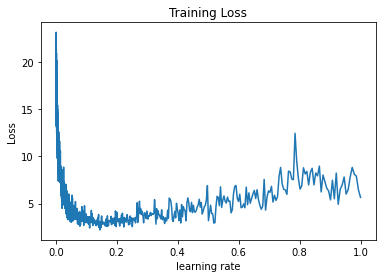

In [60]:
plt.plot(lri, lossi)  #
plt.title('Training Loss')
plt.xlabel('learning rate')
plt.ylabel('Loss')

Text(0, 0.5, 'Loss')

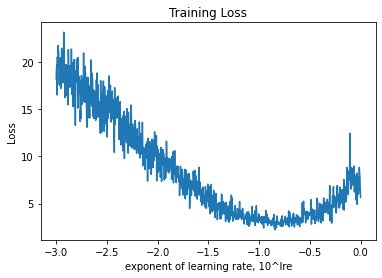

In [61]:
plt.plot(lrei, lossi) 
plt.title('Training Loss')
plt.xlabel('exponent of learning rate, 10^lre')
plt.ylabel('Loss')

---
We evenly sampled points x in some interval (say $-3$ to $0$, use `torch.linspace`) and converted them to `10**x` to create a range of learning rates. Next, we ran a training loop for these various learning rates from our sampling and plotted the loss function as a function of the learning rate. Furthermore, we plotted the loss as a function of the learning rate exponent (`log10`). Typically from the $2nd$ plot, we see a **decreasing loss function at very low learning rates, then it plateaus and finally becomes unstable (explodes/increases significantly) at high learning rates**. <u>That plateau region is our sweet spot window.</u>

We chose the optimal learning rate `lr = 0.1` and ran $3$ training loops. Then for the remaining training loops, we reduced the learning rate by a **factor of 10 (`lr = 0.01`)** as we were confident that the loss was now in the minimal territory range. This phenomenon is called **learning rate decay**.

---

------
## 2.10. Train-Val-Test Splits & Why?<a id="210"></a>
-----
Smaller loss does not always mean a better model. Sometimes, when the model is too big, with many neurons and/or parameters, <u>the  model capacity grows and therefore the model becomes more likely/capable to **overfit** our training dataset</u>. Essentially, these bigger models will try to memorize the training set. The model will generate exact replicas of the training set when we try to sample from it. There will be no new data during sampling. In addition, loss evaluation on unseen data will be very high which implies that our model has little to no predictive power.

Hence, this is why the concept of <u>train-dev-test split is very important</u>. We divide our data set into training set, development/validation set, and test sets. The **training set** is used to optimize the model parameters. The **validation set** is used for the development over all the model <u>hyper-parameters</u> (hidden layer size, embedding size, regularization strength, learning rate, etc.). The **test set** is used to evaluate the model performance. We use the test set only a few times and very sparingly to prevent overfitting the test set. A <u>typical train-dev-test percent split ratio</u> could be **80:10:10** for the size of our data ($<100,000$).

In [62]:
# build the dataset

def build_dataset(words):  
    block_size = 3 # context length: how many characters do we take to predict the next one?
    X, Y = [], []
    for w in words:

        #print(w)
        context = [0] * block_size
        for ch in w + '.':
            ix = stoi[ch]
            X.append(context)
            Y.append(ix)
            #print(''.join(itos[i] for i in context), '--->', itos[ix])
            context = context[1:] + [ix] # crop and append

    X = torch.tensor(X)
    Y = torch.tensor(Y)
    print(X.shape, Y.shape)
    return X, Y


random.seed(42)
random.shuffle(words)
n1 = int(0.8*len(words))
n2 = int(0.9*len(words))

Xtr, Ytr = build_dataset(words[:n1])
Xdev, Ydev = build_dataset(words[n1:n2])
Xte, Yte = build_dataset(words[n2:])

torch.Size([182625, 3]) torch.Size([182625])
torch.Size([22655, 3]) torch.Size([22655])
torch.Size([22866, 3]) torch.Size([22866])


In [63]:
len(words)

32033

In [64]:
# train-dev-test split
n1, n2-n1, len(words)-n2

(25626, 3203, 3204)

In [65]:
Xtr.shape, Ytr.shape # dataset

(torch.Size([182625, 3]), torch.Size([182625]))

In [66]:
g = torch.Generator().manual_seed(2147483647)     # for reproducibility
C = torch.randn((27, 2), generator=g)
W1 = torch.randn((6, 100), generator=g)
b1 = torch.randn(100, generator=g)
W2 = torch.randn((100, 27), generator=g)
b2 = torch.randn(27, generator=g)
parameters = [C, W1, b1, W2, b2]

In [67]:
sum(p.nelement() for p in parameters) # number of parameters in total

3481

In [68]:
for p in parameters:
    p.requires_grad = True

In [69]:
lre = torch.linspace(-3, 0, 1000)
lrs = 10**lre

In [70]:
lri = []
lossi = []

for i in range(10000):
    
    # minibatch construct
    ix = torch.randint(0, Xtr.shape[0], (32, ))
    
    # forward pass
    emb = C[Xtr[ix]]                               # (32, 3, 2)
    h = torch.tanh(emb.view(-1,6) @ W1 + b1)     # (32,100)
    logits = h @ W2 + b2                         # (32, 27)
    loss = F.cross_entropy(logits, Ytr[ix])
    #print(loss.item())
    
    # backward pass
    for p in parameters:
        p.grad = None
    loss.backward()

    # update parameters
#     lr = lrs[i]
    lr = 0.01
    for p in parameters:
        p.data += -lr * p.grad
        
    # track stats
#     lri.append(lr)
#     lossi.append(loss.item())

print(loss.item())

2.2595973014831543


In [71]:
emb = C[Xtr]                                 # (32, 3, 2)
h = torch.tanh(emb.view(-1,6) @ W1 + b1)     # (32,100)
logits = h @ W2 + b2                         # (32, 27)
loss = F.cross_entropy(logits, Ytr)
loss

tensor(2.5720, grad_fn=<NllLossBackward0>)

In [72]:
emb = C[Xdev]                                # (32, 3, 2)
h = torch.tanh(emb.view(-1,6) @ W1 + b1)     # (32,100)
logits = h @ W2 + b2                         # (32, 27)
loss = F.cross_entropy(logits, Ydev)
loss

tensor(2.5653, grad_fn=<NllLossBackward0>)

---
The training and validation set losses are about equal, so we're not overfitting. This model is not powerful enough to just be purely memorizing the data. In other words, the model is **underfitting** the data because the training and validation losses are roughly equal. This means our neural network is very small/tiny. One performance improvement we can make to the model is by scaling up the size of this neural network. We can do this by:
* _**increasing the `hidden layer size`**_
* _**increasing the `embedding size`**_

---

------
## 2.11. Experiment: Larger Hidden Layer<a id="211"></a>
-----
Let's <u>increase the number of neurons in the hidden layer</u> from $\boldsymbol{100}$ to $\boldsymbol{300}$ neurons.

In [73]:
g = torch.Generator().manual_seed(2147483647)     # for reproducibility
C = torch.randn((27, 2), generator=g)
W1 = torch.randn((6, 300), generator=g)
b1 = torch.randn(300, generator=g)
W2 = torch.randn((300, 27), generator=g)
b2 = torch.randn(27, generator=g)
parameters = [C, W1, b1, W2, b2]

In [74]:
sum(p.nelement() for p in parameters) # number of parameters in total

10281

In [75]:
for p in parameters:
    p.requires_grad = True

In [76]:
lre = torch.linspace(-3, 0, 1000)
lrs = 10**lre

In [77]:
lri = []
lossi = []
stepi = []

for i in range(30000):
    
    # minibatch construct
    ix = torch.randint(0, Xtr.shape[0], (32, ))
    
    # forward pass
    emb = C[Xtr[ix]]                               # (32, 3, 2)
    h = torch.tanh(emb.view(-1,6) @ W1 + b1)     # (32,100)
    logits = h @ W2 + b2                         # (32, 27)
    loss = F.cross_entropy(logits, Ytr[ix])
    #print(loss.item())
    
    # backward pass
    for p in parameters:
        p.grad = None
    loss.backward()

    # update parameters
#     lr = lrs[i]
    lr = 0.01
    for p in parameters:
        p.data += -lr * p.grad
        
    # track stats
    #lri.append(lr)
    stepi.append(i)
    lossi.append(loss.item())

print(loss.item())

2.492058277130127


Text(0, 0.5, 'Loss')

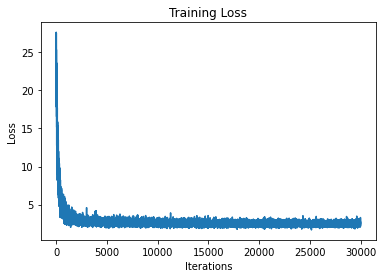

In [78]:
plt.plot(stepi, lossi)
plt.title('Training Loss')
plt.xlabel('Iterations')
plt.ylabel('Loss')

In [79]:
emb = C[Xtr]                                 # (32, 3, 2)
h = torch.tanh(emb.view(-1,6) @ W1 + b1)     # (32,100)
logits = h @ W2 + b2                         # (32, 27)
loss = F.cross_entropy(logits, Ytr)
loss

tensor(2.4651, grad_fn=<NllLossBackward0>)

In [80]:
emb = C[Xdev]                                # (32, 3, 2)
h = torch.tanh(emb.view(-1,6) @ W1 + b1)     # (32,100)
logits = h @ W2 + b2                         # (32, 27)
loss = F.cross_entropy(logits, Ydev)
loss

tensor(2.4563, grad_fn=<NllLossBackward0>)

---
The training and validation losses are still roughly equal after increasing the hidden layer size. So we're not really improving the model much more and it still underfits. Therefore, the bottleneck could be the character embedding size.

---

------
## 2.12. Visualize Character Embeddings<a id="212"></a>
-----
So far we've used $\boldsymbol{2}$-dimensional embeddings. This can be a bottleneck in our model.

Let’s try to visualize the character embeddings.

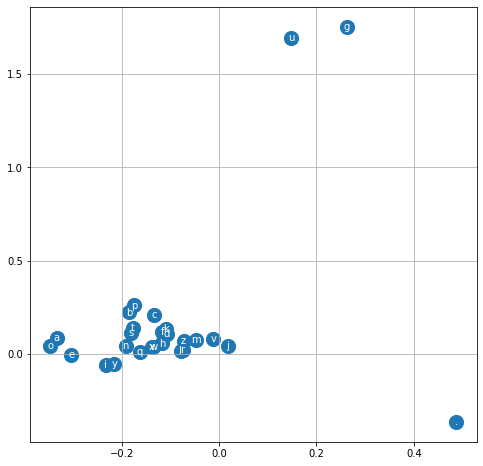

In [81]:
plt.figure(figsize = (8,8))
plt.scatter(C[:,0].data, C[:,1].data, s = 200)

for i in range(C.shape[0]):
    plt.text(C[i,0].item(),C[i,1].item(), itos[i], ha = "center", va = "center", color= "white")
plt.grid('minor')

------
## 2.13. Experiment: Larger Embedding Size<a id="213"></a>
-----


In [82]:
g = torch.Generator().manual_seed(2147483647)     # for reproducibility
C = torch.randn((27, 10), generator=g)
W1 = torch.randn((30, 200), generator=g)
b1 = torch.randn(200, generator=g)
W2 = torch.randn((200, 27), generator=g)
b2 = torch.randn(27, generator=g)
parameters = [C, W1, b1, W2, b2]

In [83]:
sum(p.nelement() for p in parameters) # number of parameters in total

11897

In [84]:
for p in parameters:
    p.requires_grad = True

In [85]:
lre = torch.linspace(-3, 0, 1000)
lrs = 10**lre

In [86]:
lri = []
lossi = []
stepi = []

In [87]:
for i in range(50000):
    
    # minibatch construct
    ix = torch.randint(0, Xtr.shape[0], (32, ))
    
    # forward pass
    emb = C[Xtr[ix]]                               # (32, 3, 2)
    h = torch.tanh(emb.view(-1,30) @ W1 + b1)     # (32,100)
    logits = h @ W2 + b2                         # (32, 27)
    loss = F.cross_entropy(logits, Ytr[ix])
    #print(loss.item())
    
    # backward pass
    for p in parameters:
        p.grad = None
    loss.backward()

    # update parameters
#     lr = lrs[i]
    lr = 0.01
    for p in parameters:
        p.data += -lr * p.grad
        
    # track stats
    #lri.append(lr)
    stepi.append(i)
    lossi.append(loss.log10().item())

print(loss.item())

2.623623847961426


Text(0, 0.5, 'Log loss')

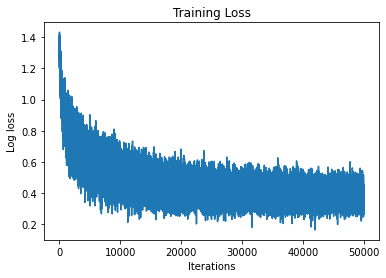

In [88]:
plt.plot(stepi, lossi)
plt.title('Training Loss')
plt.xlabel('Iterations')
plt.ylabel('Log loss')

In [89]:
emb = C[Xtr]                                 # (32, 3, 2)
h = torch.tanh(emb.view(-1,30) @ W1 + b1)    # (32,100)
logits = h @ W2 + b2                         # (32, 27)
loss = F.cross_entropy(logits, Ytr)
loss

tensor(2.4539, grad_fn=<NllLossBackward0>)

In [90]:
emb = C[Xdev]                                # (32, 3, 2)
h = torch.tanh(emb.view(-1,30) @ W1 + b1)    # (32,100)
logits = h @ W2 + b2                         # (32, 27)
loss = F.cross_entropy(logits, Ydev)
loss

tensor(2.4613, grad_fn=<NllLossBackward0>)

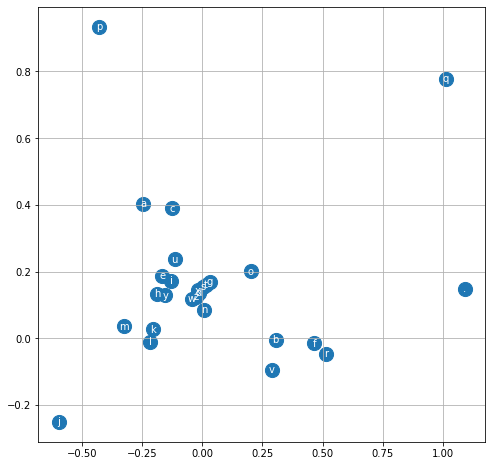

In [91]:
plt.figure(figsize = (8,8))
plt.scatter(C[:,0].data, C[:,1].data, s = 200)

for i in range(C.shape[0]):
    plt.text(C[i,0].item(),C[i,1].item(), itos[i], ha = "center", va = "center", color= "white")
plt.grid('minor')

---
We can see that the validation loss is slowly diverging from the training loss. This means that our model is slowly starting to overfit. 

<a id='d3'></a>
For further model improvements, we can change:
* the **number of neurons in hidden layer**: `W1.shape[1]` (`b1.shape == W2.shape[0]`)
* the dimensionality of the **embedding lookup table**: `C` (`m`: the embedding size)
* the number of characters fed in as input as **context** into the model: `block_size`
* the details of the optimization: 
    - **number of iterations, learning rate, & learning rate decay**
    - **batch_size**: may be able to achieve a better convergence speed
        - `ix = torch.randint(0, Xtr.shape[0], (batch_size, ))`
    
---

------
## 2.14. Summary of Final Code<a id="214"></a>
-----


In [92]:
Xtr.shape, Ytr.shape # dataset

(torch.Size([182625, 3]), torch.Size([182625]))

In [93]:
g = torch.Generator().manual_seed(2147483647)     # for reproducibility
C = torch.randn((27, 10), generator=g)
W1 = torch.randn((30, 200), generator=g)
b1 = torch.randn(200, generator=g)
W2 = torch.randn((200, 27), generator=g)
b2 = torch.randn(27, generator=g)
parameters = [C, W1, b1, W2, b2]

In [94]:
sum(p.nelement() for p in parameters) # number of parameters in total

11897

In [95]:
for p in parameters:
    p.requires_grad = True

In [96]:
lre = torch.linspace(-3, 0, 1000)
lrs = 10**lre

In [97]:
lri = []
lossi = []
stepi = []

In [98]:
for i in range(200000):
    
    # minibatch construct
    ix = torch.randint(0, Xtr.shape[0], (32, ))
    
    # forward pass
    emb = C[Xtr[ix]]                               # (32, 3, 2)
    h = torch.tanh(emb.view(-1, 30) @ W1 + b1)     # (32,100)
    logits = h @ W2 + b2                           # (32, 27)
    loss = F.cross_entropy(logits, Ytr[ix])
    #print(loss.item())
    
    # backward pass
    for p in parameters:
        p.grad = None
    loss.backward()

    # update parameters
    #lr = lrs[i]
    lr = 0.1 if i < 100000 else 0.01
    for p in parameters:
        p.data += -lr * p.grad
        
    # track stats
    #lri.append(lr)
    stepi.append(i)
    lossi.append(loss.log10().item())

print(loss.item())

2.3276724815368652


Text(0, 0.5, 'Log loss')

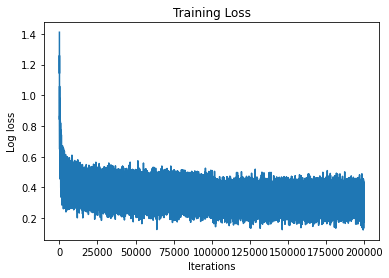

In [99]:
plt.plot(stepi, lossi)
plt.title('Training Loss')
plt.xlabel('Iterations')
plt.ylabel('Log loss')

In [100]:
emb = C[Xtr]                                 # (32, 3, 2)
h = torch.tanh(emb.view(-1,30) @ W1 + b1)    # (32,100)
logits = h @ W2 + b2                         # (32, 27)
loss = F.cross_entropy(logits, Ytr)
loss

tensor(2.1329, grad_fn=<NllLossBackward0>)

In [101]:
emb = C[Xdev]                                # (32, 3, 2)
h = torch.tanh(emb.view(-1,30) @ W1 + b1)    # (32,100)
logits = h @ W2 + b2                         # (32, 27)
loss = F.cross_entropy(logits, Ydev)
loss

tensor(2.1743, grad_fn=<NllLossBackward0>)

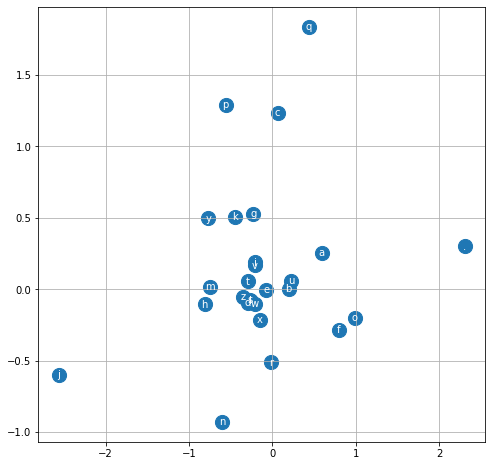

In [102]:
# visualize dimensions 0 and 1 of the embedding matrix C for all characters
plt.figure(figsize = (8,8))
plt.scatter(C[:,0].data, C[:,1].data, s = 200)
for i in range(C.shape[0]):
    plt.text(C[i,0].item(),C[i,1].item(), itos[i], ha = "center", va = "center", color= "white")
plt.grid('minor')

------
## 2.15. Sampling from the Model<a id="215"></a>
-----
Let’s generate some names using the model. We prompt the model with an initial context indicated by **`'...'`**. The model utilizes its learned weights and biases to transform this input into a set of output probabilities. From these probabilities, we randomly sample the next character to progressively build the name.

In [103]:
context = [0] * block_size
C[torch.tensor([context])].shape

torch.Size([1, 3, 10])

In [104]:
# sample from the model
g = torch.Generator().manual_seed(2147483647 + 10)

for _ in range(20):
    
    out = []
    context = [0] * block_size # initialize with all ...
    while True:
        emb = C[torch.tensor([context])] # (1,block_size,d)
        h = torch.tanh(emb.view(1, -1) @ W1 + b1)
        logits = h @ W2 + b2
        probs = F.softmax(logits, dim=1)
        ix = torch.multinomial(probs, num_samples=1, generator=g).item()
        context = context[1:] + [ix]
        out.append(ix)
        if ix == 0:
            break

    print(''.join(itos[i] for i in out))

carmah.
amelle.
khismilialaty.
salaysleer.
hutlaymerric.
kaeli.
nellara.
chaiiv.
kaleigh.
ham.
jois.
quinn.
shorden.
jadii.
waje.
madiaryxi.
jace.
pirran.
edde.
oib.


---------
<br><br>
# 3. Conclusion<a id="3"></a>
-------------------------------------------------------
In this notebook we implemented a multilayer perceptron (MLP) model as the character-level language model to handle the issue of **curse of dimensionality** from the n-gram character-level models. We aim to address the limitations of the bigram and trigram language models, particularly their struggle to produce name-like names because of their restrictions to <u>only a single preceding character</u> analysis.  During the building and training of the model, some of the concepts we learned about were <u>**embeddings, minibatches, hyperparameter optimization, under/overfitting, dataset train-dev-test splits, & model evaluation.**</u>

This notebook explains how to build a language model using neural networks. It covers the fundamental concepts of training a neural network on a training set and evaluating its performance on a test set, as well as splitting data into train, development, and test sets. The series also delves into the specifics of how a neural network can predict the next character in a sequence, and how to use the Torch library for language modeling operations. Additionally, it demonstrates how to build a language model using the "logistic" neural net shape and create a language model that can predict the next character in a sequence.

This notebook also covers more advanced topics, such as how to perform forward and backward passes in language modeling, determine a learning rate for a language model, and optimize the model for better performance. It covers how to improve model performance by tuning optimization parameters and increasing the number of input characters. Overall, this notebook offers a comprehensive guide to building and optimizing language models using neural networks, making it a valuable resource for anyone looking to learn about this topic.

---------
<br><br>
# Appendix: Tensor Manipulations<a id="d4"></a>
-------------------------------------------------------

We go over tensor manipulations in `PyTorch` that can be helpful for mathematical operations of matrices and tensors. We go over two `torch` methods.

### Concatenation
----

In [105]:
test = torch.tensor([[[2, 3],
                   [4, 5],
                   [6, 7]],
                    
                   [[8, 9],
                    [10, 11],
                    [12, 13]]])
test

tensor([[[ 2,  3],
         [ 4,  5],
         [ 6,  7]],

        [[ 8,  9],
         [10, 11],
         [12, 13]]])

In [106]:
test_cat = torch.cat([test[:, 0, :], test[:, 1, :], test[:, 2, :]], 1)
test_cat

tensor([[ 2,  3,  4,  5,  6,  7],
        [ 8,  9, 10, 11, 12, 13]])

In [107]:
test.shape, test_cat.shape

(torch.Size([2, 3, 2]), torch.Size([2, 6]))

### View
----
`.view` is much more efficient and the underlying `PyTorch` storage does not change. Furthermore, no new additional memory is allocated.

In [108]:
a = torch.arange(18)
a

tensor([ 0,  1,  2,  3,  4,  5,  6,  7,  8,  9, 10, 11, 12, 13, 14, 15, 16, 17])

In [109]:
a.shape

torch.Size([18])

In [110]:
a.view(2, 9) # extremely efficient

tensor([[ 0,  1,  2,  3,  4,  5,  6,  7,  8],
        [ 9, 10, 11, 12, 13, 14, 15, 16, 17]])

In [111]:
a.view(9, 2)

tensor([[ 0,  1],
        [ 2,  3],
        [ 4,  5],
        [ 6,  7],
        [ 8,  9],
        [10, 11],
        [12, 13],
        [14, 15],
        [16, 17]])

In [112]:
a.view(3, 3, 2)

tensor([[[ 0,  1],
         [ 2,  3],
         [ 4,  5]],

        [[ 6,  7],
         [ 8,  9],
         [10, 11]],

        [[12, 13],
         [14, 15],
         [16, 17]]])

In [113]:
a.storage()

 0
 1
 2
 3
 4
 5
 6
 7
 8
 9
 10
 11
 12
 13
 14
 15
 16
 17
[torch.LongStorage of size 18]

---------
<br><br>
# Appendix: Embeddings<a id="d5"></a>
-------------------------------------------------------

We go over embeddings and embedding lookup tables in `PyTorch` that are necessary for the MLP model we build in this notebook. *Embedding an integer* means mapping the integer to a feature vector. Let's go through various types of embeddings.

### Single Integer Embedding
----

In [114]:
# Direct indexing access
print(C[1])


# Using one-hot encoding 
print(F.one_hot(torch.tensor(1), num_classes=27).float() @ C)

tensor([ 0.5915,  0.2553, -1.2696, -0.4579,  0.4209,  3.0067,  1.9783, -1.1180,
         0.9884, -1.3976], grad_fn=<SelectBackward0>)
tensor([ 0.5915,  0.2553, -1.2696, -0.4579,  0.4209,  3.0067,  1.9783, -1.1180,
         0.9884, -1.3976], grad_fn=<SqueezeBackward3>)


### Multiple Integers Embedding
----

In [115]:
# You can use lists to embed multiple integers at once.
print(C[[0, 1, 2]])


# Tensors will work as well
x = torch.tensor([0, 1, 2])
print(C[x])

tensor([[ 2.3033e+00,  3.0027e-01,  3.8556e-01, -1.1099e+00,  1.3141e-01,
          4.6951e-01, -2.0946e+00,  1.4270e+00,  5.9253e-01,  2.0175e+00],
        [ 5.9151e-01,  2.5531e-01, -1.2696e+00, -4.5790e-01,  4.2094e-01,
          3.0067e+00,  1.9783e+00, -1.1180e+00,  9.8836e-01, -1.3976e+00],
        [ 1.9471e-01,  1.6241e-03, -6.8770e-01, -3.3083e-01,  3.3575e-01,
          8.5847e-01,  8.4312e-01,  1.4996e-02, -1.4439e-01,  3.6371e-01]],
       grad_fn=<IndexBackward0>)
tensor([[ 2.3033e+00,  3.0027e-01,  3.8556e-01, -1.1099e+00,  1.3141e-01,
          4.6951e-01, -2.0946e+00,  1.4270e+00,  5.9253e-01,  2.0175e+00],
        [ 5.9151e-01,  2.5531e-01, -1.2696e+00, -4.5790e-01,  4.2094e-01,
          3.0067e+00,  1.9783e+00, -1.1180e+00,  9.8836e-01, -1.3976e+00],
        [ 1.9471e-01,  1.6241e-03, -6.8770e-01, -3.3083e-01,  3.3575e-01,
          8.5847e-01,  8.4312e-01,  1.4996e-02, -1.4439e-01,  3.6371e-01]],
       grad_fn=<IndexBackward0>)


### Embedding using multi-dimensional tensor
----

In [116]:
x = torch.tensor([
    [0, 1, 2], 
    [0, 1, 2]
])
print(C[x])

tensor([[[ 2.3033e+00,  3.0027e-01,  3.8556e-01, -1.1099e+00,  1.3141e-01,
           4.6951e-01, -2.0946e+00,  1.4270e+00,  5.9253e-01,  2.0175e+00],
         [ 5.9151e-01,  2.5531e-01, -1.2696e+00, -4.5790e-01,  4.2094e-01,
           3.0067e+00,  1.9783e+00, -1.1180e+00,  9.8836e-01, -1.3976e+00],
         [ 1.9471e-01,  1.6241e-03, -6.8770e-01, -3.3083e-01,  3.3575e-01,
           8.5847e-01,  8.4312e-01,  1.4996e-02, -1.4439e-01,  3.6371e-01]],

        [[ 2.3033e+00,  3.0027e-01,  3.8556e-01, -1.1099e+00,  1.3141e-01,
           4.6951e-01, -2.0946e+00,  1.4270e+00,  5.9253e-01,  2.0175e+00],
         [ 5.9151e-01,  2.5531e-01, -1.2696e+00, -4.5790e-01,  4.2094e-01,
           3.0067e+00,  1.9783e+00, -1.1180e+00,  9.8836e-01, -1.3976e+00],
         [ 1.9471e-01,  1.6241e-03, -6.8770e-01, -3.3083e-01,  3.3575e-01,
           8.5847e-01,  8.4312e-01,  1.4996e-02, -1.4439e-01,  3.6371e-01]]],
       grad_fn=<IndexBackward0>)


-----
<br><br><a id="e1"></a>
# Exercises
----
1. Tune the hyperparameters of the training to beat **karpathy's best validation loss of 2.2**.
2. I was not careful with the intialization of the network in this video.
    1. What is the loss you'd get if the predicted probabilities at initialization were perfectly uniform? What loss do we achieve? 
    2. Can you tune the initialization to get a starting loss that is much more similar to (1)?
3. Read the [Bengio et al 2003 paper](https://www.jmlr.org/papers/volume3/bengio03a/bengio03a.pdf), implement and try any idea from the paper. Did it work?

-----
<br><br><a id="r1"></a>
# References
----
1. "<u>Building makemore Part 2: MLP</u>" [youtube video](https://www.youtube.com/watch?v=TCH_1BHY58I), Sept 2022.
2. Andrej Karpathy **Makemore** [github repo](https://github.com/karpathy/makemore).
3. Andrej Karpathy  **Neural Networks: Zero to Hero** [github repo](https://github.com/karpathy/nn-zero-to-hero/tree/master) ([notebook](https://github.com/karpathy/nn-zero-to-hero/blob/master/lectures/makemore/makemore_part2_mlp.ipynb) to follow video tutorial with).
4. Article: "<u>Multilayer Perceptron with Andrej Karpathy</u>" - Kavishka Abeywardana, Pt [1](https://medium.com/@kdwa2404/multilayer-perceptron-with-andrej-karpathy-part-1-7f530278c2b7), [2](https://medium.com/@kdwa2404/multilayer-perceptron-with-andrej-karpathy-part-2-38a75dc2e5a4), March 2024.
5. Article: "<u>Implementing a Character-Level Language Model Using MLP</u>" - Tahir Rauf, Pt [2A](https://blog.gopenai.com/implementing-a-character-level-bigram-language-model-using-mlp-part-2a-73e79dd0ae8d), [2B](https://ai.plainenglish.io/implementing-a-character-level-bigram-language-model-using-mlp-part-2-b-c72a126b32a3), Dec 2023.
6. "<u>Deep Dive into AI: Analyzing and implementing Multilayer Perceptrons</u>" - Ada Choudhry, [article](https://medium.com/@adachoudhry26/deep-dive-into-ai-analyzing-and-implementing-multilayer-perceptrons-f8acaecfd846), Jan 2024.
7. "<u>Notes on Andrej Karpathy’s makemore videos. Part 2.</u>" - Maxime Markov, [article](https://medium.com/@maxmarkovvision/notes-on-andrej-karpathys-makemore-videos-part-2-58ee51912c5c), Nov 2022.
8. "<u>What Is the Curse of Dimensionality?</u>" - Badreesh Shetty, [article](https://builtin.com/data-science/curse-dimensionality), Aug 2022.
9. "<u>The Curse of Dimensionality in Machine Learning: Challenges, Impacts, and Solutions</u>" - Abid Ali Awan, [article](https://www.datacamp.com/blog/curse-of-dimensionality-machine-learning), Sep 2023.
10. "<u>A Neural Probabilistic Language Model</u>" - Bengio et. al. [Academic Paper](https://www.jmlr.org/papers/volume3/bengio03a/bengio03a.pdf), 2003
11. PyTorch Resources: [`torch.cat`](https://pytorch.org/docs/stable/generated/torch.cat.html), [`torch.Tensor.view`](https://pytorch.org/docs/stable/generated/torch.Tensor.view.html)
12. Wikipedia: [Autoregressive Model](https://en.wikipedia.org/wiki/Autoregressive_model)
13. Stack Overflow: [`np.random.rand` vs `np.random.randn`](https://stackoverflow.com/questions/47240308/differences-between-numpy-random-rand-vs-numpy-random-randn-in-python)

------